# Lac Pavin data binning and curation

In [1]:
import matplotlib, re, os, glob, datetime, difflib, random, time, math, json, wget
import matplotlib.pyplot as plt
import seaborn as sns
from drep import d_cluster
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO, SeqUtils, SearchIO

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)
            
def encode(assembly):
    return "A" + "".join(os.path.basename(assembly).split("_")[1:3])

In [3]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/"

# binning

In [5]:
cmdir(rootdir + "binning")
cmdir(rootdir + "binning/mapping")

### define samples/reads

In [4]:
# gather read files
reads = {"water_column":[], "sediment":[]}

# project dir
for sample in glob.glob(rootdir.replace("analysis/", "QB3*/raw.d/*/")):
    if (("Creux" not in sample) and ("07_03" not in sample)):
        fwd = glob.glob(sample + "/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "/*.PE.2.fastq.gz")[0]
        reads["water_column"].append((fwd,rev))

# /banfield/sequences
for sample in glob.glob("/groups/banfield/sequences/2020/LacPavin*/"):
    if "ALN" not in sample:
        fwd = glob.glob(sample + "raw.d/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "raw.d/*.PE.2.fastq.gz")[0]
        if "SED" in sample:
            reads["sediment"].append((fwd, rev))
        else: reads["water_column"].append((fwd, rev))

In [5]:
# define samples/assemblies of interest
assemblies = {"water_column":[], "sediment":[]}
for assembly in glob.glob(rootdir.replace("analysis/", "QB3*/assembly.d/*/*megahit*/*min1000.fa")):
    if ("Creux" not in assembly) and ("ALN" not in assembly):
        if "SED" in assembly:
            assemblies["sediment"].append(assembly)
        else: assemblies["water_column"].append(assembly)

### cross mapping

In [38]:
for biome in assemblies:
    
    for assembly in assemblies[biome]:
    
        #assembly shorthand
        acode = encode(assembly)
        
        #open job file
        with open(rootdir + "binning/mapping/" + acode + ".sh", "w") as outfile:

            # bowtie build
            build = "/shared/software/bin/bowtie2-build --threads 48 " + assembly + \
                " " + rootdir + "binning/mapping/" + acode
            outfile.write(build + "\n")

            for read_tuple in reads[biome]:

                # read shorthand
                rcode = "R" + "".join(os.path.basename(read_tuple[0]).split("_")[1:3])
                filecode = rootdir + "/binning/mapping/" + acode + "_" + rcode
                # generate mapping
                mapping = "/shared/software/bin/bowtie2 -p 48 -x " + rootdir + "binning/mapping/" + acode + " -1 " + \
                    read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
                    " | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + filecode + ".bam"
                outfile.write(mapping + "\n")
                # generate sorted bam + idx
                sort = "/shared/software/bin/samtools sort --threads 45 " + filecode + ".bam > " + filecode + ".sorted.bam"
                index = "/shared/software/bin/samtools index -@ 48 " + filecode + ".sorted.bam"
                outfile.write(sort + "\n" + index + "\n")     

`chmod +x *` then `for item in $(ls *.sh); do sbatch --wrap $(pwd)/$item; done`

### metabat

In [39]:
cmdir(rootdir + "binning/metabat")

In [44]:
# generate depth files
with open(rootdir + "scripts/runJGI.sh", "w") as outfile:
    
    for biome in assemblies:
        for assembly in assemblies[biome]:
            #assembly shorthand
            acode = encode(assembly)
            jgi = "/shared/software/bin/jgi_summarize_bam_contig_depths --outputDepth " + rootdir + \
                "binning/metabat/" + acode + ".txt " + rootdir + "binning/mapping/" + acode + "*sorted.bam"
            #sp.call(jgi, shell=True)
            outfile.write(jgi + "\n")

In [46]:
# run metabat per assembly
for biome in assemblies:
    
    for assembly in assemblies[biome]:
    
        #assembly shorthand
        acode = encode(assembly)
    
        cmdir(rootdir + "binning/metabat/" + acode + "_bins/")
        metabat = "sbatch -J " + "MB_" + acode + " --wrap '/shared/software/bin/metabat2 -t 48 -m 1500 -i " + assembly + " -a " + \
            rootdir + "binning/metabat/" + acode + ".txt -o " + rootdir + "binning/metabat/" + acode + "_bins/" + acode + "'"
        sp.call(metabat, shell=True)

### ggk manual

In [47]:
cmdir(rootdir + "binning/ggkbase")

Manually put ggkbase project scaf2bin in this folder for use below.

### DASTool

In [51]:
cmdir(rootdir + "binning/dastool")
cmdir(rootdir + "binning/dastool/scaf2bin")

In [52]:
for scaf2bin in glob.glob(rootdir + "binning/ggkbase/*"):
    
    table = pd.read_csv(scaf2bin, sep = "\t")
    # filter out phage, virus, unk
    filt = table[~table["bin"].str.contains("phage|Phage|Virus|UNK")]
    
    #write to dastool directory
    acode = "A" + "".join(os.path.basename(scaf2bin).split("_")[1:3]).split(".")[0]
    filename = rootdir + "binning/dastool/scaf2bin/" + acode + ".ggkbase.scaf2bin"

    with open(filename, "w") as outfile:
        for key, row in filt.iterrows():
            outfile.write(row["scaffold_name"] + "\t" + row["bin"] + "\n")

In [53]:
# generate scaffold to bin - rename bins
for sample in glob.glob(rootdir + "binning/metabat/*bins/"):

    acode = sample.split("/")[-2].split("_")[0]
    filename = rootdir + "binning/dastool/scaf2bin/" + acode + ".metabat.scaf2bin"
    
    with open(filename, "w") as outfile:
        for bin in glob.glob(sample + "/*fa"):
            newname = os.path.basename(bin).replace(acode, acode + ".metabat")
            # write out scaf2bin w/ newnames
            for record in SeqIO.parse(open(bin), "fasta"):
                outfile.write(record.description.split(" ")[0] + "\t" + newname + "\n")

In [59]:
with open(rootdir + "scripts/runDasTool.sh", "w") as outfile:
    for biome in assemblies:
        for assembly in assemblies[biome]:
            acode = encode(assembly)
            tables = ",".join(glob.glob(rootdir + "binning/dastool/scaf2bin/" + acode + "*"))
            labels = ",".join(os.path.basename(path).split(".")[1] 
                for path in glob.glob(rootdir + "binning/dastool/scaf2bin/" + acode + "*"))

            cmdir(rootdir + "binning/dastool/" + acode + "/")
            dastool = "sbatch -J DT" + acode + " --wrap '/shared/software/bin/DAS_Tool -t 48 -i " + tables + " -l " + \
                labels + " -c " + assembly + " -o " + rootdir + "binning/dastool/" + acode + "/" + acode + " --write_bins'"
            outfile.write(dastool + "\n")

### reupload to ggkbase

In [536]:
cmdir(rootdir + "ggkbase/temp_scaf2bin")

In [686]:
# cleanse old non-phage bins
for file in glob.glob(rootdir + "ggkbase/temp_scaf2bin/*tsv"):
    with open(rootdir + "ggkbase/temp_scaf2bin/" + \
        os.path.basename(file).split("scaffolds")[0] + "clean.txt", "w") as out:
        bins = []
        for key, row in pd.read_csv(file, sep="\t").iterrows():
            if ("UNK" not in row["bin"]) and ("PHAGE" not in row["bin"].upper()) and ("VIRUS" not in row["bin"].upper()):
                bins.append(row["bin"])
        for bin in list(set(bins)):
            out.write(bin + "\t" + os.path.basename(file).split(".scaffolds")[0] + "\n")

In [688]:
cmdir(rootdir + "ggkbase/dastool_scaf2bin_cleaned")

In [689]:
# rename dastool output
for file in glob.glob(rootdir + "/binning/dastool/A*/*scaffolds2bin.txt"):
    name = os.path.basename(file).replace(".txt", "_cleaned.txt")
    with open(rootdir + "ggkbase/dastool_scaf2bin_cleaned/" + name, "w") as out:
        for line in open(file).readlines():
            out.write(line.replace(".fa", ""))

# genome curation prep

In [555]:
cmdir(rootdir + "genomes")
cmdir(rootdir + "genomes/prelim_genomes")

Copy all dastool genomes over to prelim_genomes folder in terminal.

### prelim gtdb-tk run

In [ ]:
cmdir(rootdir + "genomes/gtdb-tk/")

In [757]:
genomes = glob.glob(rootdir + "genomes/prelim_genomes/*")
n = math.ceil(len(genomes)/10)

for a, i in enumerate(range(0, len(genomes), n)):
    with open(rootdir + "genomes/gtdb-tk/batch%d.txt" %(a), "w") as out:
        for genome in genomes[i:i + n]:
            out.write(genome + "\t" + os.path.basename(genome).split(".fa")[0] + "\n")

In [759]:
for batchfile in glob.glob(rootdir + "genomes/gtdb-tk/batch*.txt"):
    dirname = rootdir + "genomes/gtdb-tk/%s" %(os.path.basename(batchfile).replace(".txt", ""))
    call = "sbatch --wrap '/shared/software/bin/gtdbtk classify_wf --cpus 48 -x .fa --batchfile %s --out_dir %s'" %(batchfile, dirname)
    #print(call)

In [6]:
# parse
gtresults = pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "genomes/gtdb-tk/batch*/gtdbtk.*.summary.tsv")])

### cpr/dpann completeness

In [849]:
cmdir(rootdir + "genomes/quality")
cmdir(rootdir + "genomes/quality/scg")

In [7]:
dpann_phyla = ["p__Nanoarchaeota", "p__Huberarchaeota", "p__UAP2", "p__EX4484-52", "p__Nanohaloarchaeota", "p__Iainarchaeota", "p__Aenigmatarchaeota", "p__Micrarchaeota"]
gtresults["phylum"] = gtresults["classification"].apply(lambda x: x.split(";")[1])
cpr_dpann = gtresults[(gtresults["phylum"].isin(dpann_phyla)) | (gtresults["phylum"]=="p__Patescibacteria")]
cpr_dpann["phylum"].value_counts()

p__Patescibacteria      240
p__Nanoarchaeota         27
p__Micrarchaeota         17
p__Aenigmatarchaeota     10
p__Iainarchaeota          7
Name: phylum, dtype: int64

In [322]:
# problem bins - those needing the _sub
problem_bins = ["A0419WC90_metabat_209", "A0419WC90_metabat_52", "A0419WC90_metabat_130", 
                "A0419WC90_metabat_43", "A0818WC45_metabat_401", "A0818WC45_metabat_191", 
                "A0920WC90_metabat_16", "A0419WC90_metabat_203", "A0818WC55_metabat_187", "A0818WC55_metabat_70"]

In [949]:
# write out for bulk ggkbase pulldown
with open(rootdir + "genomes/quality/cpr_dpann_prelim_bins.tsv", "w") as out:
    for key, row in cpr_dpann.iterrows():
        
        domain = row["classification"].split(";")[0].replace("d__","")
        if "LacPavin" in row["user_genome"]:
            slug = "_".join(row["user_genome"].split("_")[0:3])
        else:
            m = re.search("A([0-9]*)([A-Z0-9]*)", row["user_genome"])
            slug = "LacPavin_%s_%s" %(m.group(1), m.group(2))
        
        genome_name = row["user_genome"].replace(".contigs","").replace(".", "_")
        if genome_name in problem_bins:
            genome_name += "_sub"
        out.write(genome_name + "\t" + slug + "\t" + domain + "\n")

In [8]:
# define bacterial scgs
ncomms = pd.read_csv(rootdir + "genomes/quality/ncomms_supp4.csv")
bac_scgs = [item.lower() for item in ncomms.columns if item not in ["Organism", "Phylum", "Genome completion estimate (%)"]]
# define archaeal scgs
ncomms_arc = pd.read_csv(rootdir + "genomes/quality/ncomms_supp5.csv")
arc_scgs = [item.lower() for item in ncomms_arc.columns if item not in ["Organism", "Phylum", "Genome completion estimate (%)", 'Unnamed: 41']]
scgs = {"archaea": arc_scgs, "bacteria": bac_scgs}

In [9]:
# generate scaf2bin + bin2domain
prelim_scaf2bin = {}

for bin in glob.glob(rootdir + "genomes/prelim_genomes/*"):
    for record in SeqIO.parse(open(bin), "fasta"):
        prelim_scaf2bin[record.description.split(" ")[0]] = os.path.basename(bin).split(".fa")[0]

bin2domain = {row["user_genome"]: row["classification"].split(";")[0]
                 for key, row in cpr_dpann.iterrows()}

In [10]:
len(cpr_dpann)

301

In [11]:
gquality = defaultdict(list)

for scg_table in glob.glob(rootdir + "genomes/quality/scg/*"):
    
    scg_dict = {}
    table = pd.read_csv(scg_table, sep="\t")

    for key, row in table.groupby(table.columns[0], as_index=False).count().iterrows():
        scg_dict[row[table.columns[0]].lower()] = row["features"]
    
    domain = bin2domain[prelim_scaf2bin[table["contig"][0]]].replace("d__", "").lower()
    
    #compute completeness/redundancy
    markers_present, markers_redundant = 0,0
    
    for marker in scgs[domain]:
        if marker in scg_dict.keys():
            markers_present +=1
            if scg_dict[marker] > 1:
                markers_redundant +=1
    
    bin_name = glob.glob(rootdir + "genomes/prelim_genomes/" + \
        prelim_scaf2bin[table["contig"][0]] + ".*")[0]
    gquality["genome"].append(os.path.basename(bin_name))
    gquality["completeness"].append(markers_present/len(scgs[domain])*100)
    gquality["contamination"].append(markers_redundant/len(scgs[domain])*100)
       
gquality_df = pd.DataFrame(gquality)

In [12]:
len(gquality_df["genome"].unique())

301

### checkm everything else

In [ ]:
cmdir(rootdir + "genomes/quality/genomes_other")

In [ ]:
for genome in gtresults[~gtresults["user_genome"].isin(cpr_dpann["user_genome"].to_list())]["user_genome"].unique():
    genome_path = glob.glob(rootdir + "genomes/prelim_genomes/" + genome + ".*fa")
    sp.call("cp %s %s" %(genome_path[0], rootdir + "genomes/quality/genomes_other/"), shell=True)

In [346]:
call = "sbatch -J checkm --wrap '/shared/software/bin/checkm lineage_wf -t 48 -x .fa " + \
    rootdir + "/genomes/quality/genomes_other/ " + rootdir + "genomes/quality/genomes_other_checkm/'"
call2 = "checkm qa -t 16 -o 1 -f output_table.txt --tab_table lineage.ms ."
print(call2)

checkm qa -t 16 -o 1 -f output_table.txt --tab_table lineage.ms .


In [347]:
### redos for Alti
call = "/shared/software/bin/checkm lineage_wf -t 10 -x .fa " + \
    rootdir + "/genomes/raw_redos/ " + rootdir + "genomes/quality/redo_genomes_other_checkm/"
print(call)

/shared/software/bin/checkm lineage_wf -t 10 -x .fa /groups/banfield/projects/environmental/LacPavin/analysis//genomes/raw_redos/ /groups/banfield/projects/environmental/LacPavin/analysis/genomes/quality/redo_genomes_other_checkm/


In [13]:
# read in and incorporate
otherdf = pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "genomes/quality/*genomes_other_checkm/output_table.txt")])
otherdf["genome"] = otherdf["Bin Id"].apply(lambda x: x + ".fa")
otherdf_sub = otherdf[["genome", "Completeness", "Contamination"]]
otherdf_sub.columns = ["genome", "completeness", "contamination"]
otherdf_sub.head()

,genome,completeness,contamination
0,A0419WC90.metabat.56.fa.contigs.fa,50.23,0.93
1,A0920SED1.metabat.133.fa.contigs.fa,61.51,0.93
2,A0920SED5.metabat.204.fa.contigs.fa,65.76,1.49
3,A0920SED5.metabat.386.fa.contigs.fa,77.96,0.00
0,A0419WC53.metabat.10.fa.contigs.fa,96.29,1.58


In [14]:
#combine cpr/dpann +others
combined = pd.concat([gquality_df, otherdf_sub])

In [15]:
len(combined)

2035

### alti redos

In [16]:
gtresults[gtresults["classification"].str.contains("Alt")][["user_genome", "classification"]]

,user_genome,classification
6,A0920SED5.metabat.204,d__Archaea;p__Altarchaeota;c__;o__;f__;g__;s__
7,A0920SED1.metabat.133,d__Archaea;p__Altarchaeota;c__;o__;f__;g__;s__
5,A0419WC90.metabat.56,d__Archaea;p__Altarchaeota;c__Altarchaeia;o__I...
5,A0920SED5.metabat.386,d__Archaea;p__Altarchaeota;c__Altarchaeia;o__I...


In [17]:
combined[combined["genome"].str.contains("A0920SED5.metabat.386")]

,genome,completeness,contamination
3,A0920SED5.metabat.386.fa.contigs.fa,77.96,0.0


Re-computed Alti quality shows only one gets through based on completeness (386). This one formed own cluster in dRep, so just replace original Alti (204) with this one, recurate, and keep moving.

### preliminary dRep

Do this to cut down on # of genomes to curate manually, in the absence of better options. The hope is that manual curation will 'save' some bins that might have been tossed in a more stringent dRep.

In [363]:
cmdir(rootdir + "genomes/drep_prelim/")
combined.to_csv(rootdir + "genomes/drep_prelim/genomeInformation.csv", sep=",", index=False)

In [364]:
call = "sbatch -J drep --wrap '/shared/software/bin/dRep dereplicate " + rootdir + "/genomes/drep_prelim/" + \
    " -sa 0.95 -p 48 -comp 70 -con 100 -d -g " + rootdir + "/genomes/prelim_genomes/*fa --genomeInfo " + \
    rootdir + "genomes/drep_prelim/genomeInformation.csv'"
print(call)

sbatch -J drep --wrap '/shared/software/bin/dRep dereplicate /groups/banfield/projects/environmental/LacPavin/analysis//genomes/drep_prelim/ -sa 0.95 -p 48 -comp 70 -con 100 -d -g /groups/banfield/projects/environmental/LacPavin/analysis//genomes/prelim_genomes/*fa --genomeInfo /groups/banfield/projects/environmental/LacPavin/analysis/genomes/drep_prelim/genomeInformation.csv'


In [18]:
print("prelim dRep cut down %d bins to %d." %(len(glob.glob(rootdir+"genomes/prelim_genomes/*")), len(glob.glob(rootdir+"genomes/drep_prelim/dereplicated_genomes/*"))))

prelim dRep cut down 2035 bins to 788.


# genome curation

### anvio

In [183]:
adir = rootdir + "anvio/"
cmdir(adir)
cmdir(adir + "/assembly.d/")
cmdir(adir + "/contig.db/")
cmdir(adir + "profiles")
cmdir(adir + "binning")
cmdir(adir + "binning/scaf2bin")

In [527]:
# clean assembly deflines
for biome in assemblies.keys():
    for assembly in assemblies[biome]:
        call = "cat " + assembly + " | sed -r 's/(>\S+).+/\\1/' > " + \
            rootdir + "anvio/assembly.d/" + encode(assembly) + ".fa"
        sp.call(call, shell=True)

In [531]:
# create gene calls table
for biome in assemblies.keys():
    
    for assembly in assemblies[biome]:
    
        orfinfo = defaultdict(list)
        count = 1

        for record in SeqIO.parse(open(assembly.replace(".fa", ".fa.genes.faa")), "fasta"):

            split = record.description.split(" # ")
            info = split[-1].split(";")

            orfinfo["gene_callers_id"].append(count)
            orfinfo["contig"].append(scaffold(split[0]))
            orfinfo["start"].append(int(split[1])-1)
            orfinfo["stop"].append(int(split[2])-1)
            orfinfo["direction"].append("f" if split[3]=="1" else "r")
            orfinfo["partial"].append(1 if "1" in info[1] else 0)
            orfinfo["source"].append("prodigal")
            orfinfo["version"].append("v2.6.3")
            orfinfo["aa_sequence"].append(str(record.seq))
            count+=1

        orfdf = pd.DataFrame(orfinfo)
        orfdf.to_csv(rootdir + "anvio/assembly.d/" + encode(assembly) + ".genes.tsv", sep="\t", index=False)

In [532]:
# generate contig db
with open(adir + "contig.db/createCDB.sh", "w") as outfile:
    
    for sample in glob.glob(adir + "assembly.d/*fa"):

        name = os.path.basename(sample).replace(".fa", "")
        call = "anvi-gen-contigs-database -f " + sample + " -o " + adir + "contig.db/" + \
            name + ".contig.db -n " + name + " -L -999 --external-gene-calls " + sample.replace("fa", "genes.tsv")
        outfile.write(call + "\n")

In [365]:
# run hmms
with open(adir + "contig.db/runHMMs.sh", "w") as outfile:
    for db in glob.glob(adir + "contig.db/*contig.db"):
        call = "anvi-run-hmms --num-threads 16 -c " + db
        outfile.write(call + "\n") 

In [370]:
# construct profiles
with open(adir + "profiles/createProfiles.sh", "w") as outfile:
    
    for db in glob.glob(adir + "contig.db/*contig.db"):
        
        if "SED1" not in db:
            name = os.path.basename(db).replace(".contig.db", "")

            for mapping in glob.glob(rootdir + "/binning/mapping/" + name + "*sorted.bam"):

                comboname = os.path.basename(mapping).replace(".sorted.bam","")
                call = "anvi-profile --min-contig-length 1000 --num-threads 16 -i " + \
                    mapping + " -c " + db + " -o " + adir + "profiles/" + comboname + " -S " + comboname + ""
                outfile.write(call + "\n")

Run note: some python error hit with --skip-SNV-profiling option, so removed for now.

In [378]:
# merge profiles
cmdir(adir + "/profiles/merged/")

with open(adir + "profiles/merged/merge.sh", "w") as outfile:
    for db in glob.glob(adir + "contig.db/*contig.db"):
        name = os.path.basename(db).replace(".contig.db", "")
        call = "anvi-merge --skip-hierarchical-clustering " + adir + "profiles/" + name + "*/PROFILE.db" + \
            " -o " + adir + "profiles/merged/" + name + "-MERGED -c " + db + " -S " + name
        outfile.write(call + "\n")

In [606]:
# generate scaf2bin for drep genomes
dscaf2bin = {}

for bin in glob.glob(rootdir + "genomes/prelim_genomes/*"):
    for record in SeqIO.parse(open(bin), "fasta"):
        dscaf2bin[record.description.split(" ")[0]] = os.path.basename(bin)

# read into df     
ddf = pd.DataFrame.from_dict(dscaf2bin, orient="index").reset_index()
ddf.columns = ["scaffold", "bin"]

In [607]:
# write out sample specific scaf2bins
ddf["sample"] = ddf["bin"].apply(lambda x: ("A" + \
    "".join(x.split("_")[1:3]) if "Lac" in x else x.split(".")[0]))

for sample in ddf["sample"].unique():
    with open(adir + "binning/scaf2bin/" + sample + ".scaf2bin.txt", "w") as outfile:
        for key, row in ddf[ddf["sample"]==sample].iterrows():
            outfile.write(row["scaffold"] + "\t" + row["bin"].replace(".", "_") + "\n")

In [609]:
# import collection
with open(adir + "binning/importcollections.sh", "w") as out:
    for db in glob.glob(adir + "contig.db/*contig.db"):
        name = os.path.basename(db).replace(".contig.db", "")
        scaf2bin = glob.glob(adir + "binning/scaf2bin/*" + name + "*")[0]
        call = "anvi-import-collection --contigs-mode " + scaf2bin + " -p " + adir + "/profiles/merged/" + \
            name + "-MERGED/PROFILE.db -c " + db + " -C 'PRELIM'"
        out.write(call + "\n")

In [184]:
## finally, split merged profiles to be bin specific
## this speeds up the refine load by 10x
for db in glob.glob(adir + "contig.db/*contig.db"):
    name = os.path.basename(db).replace(".contig.db", "")
    # specify sample here
    if name in ["A0818WC50"]:
        call = "anvi-split -p %s -c %s -C PRELIM -o %s" \
            %(rootdir + "anvio/profiles/merged/" + name + "-MERGED/PROFILE.db", 
              rootdir + "anvio/contig.db/" + name + ".contig.db", rootdir + "anvio/profiles/split/" + name)
        print(call)

anvi-split -p /groups/banfield/projects/environmental/LacPavin/analysis/anvio/profiles/merged/A0818WC50-MERGED/PROFILE.db -c /groups/banfield/projects/environmental/LacPavin/analysis/anvio/contig.db/A0818WC50.contig.db -C PRELIM -o /groups/banfield/projects/environmental/LacPavin/analysis/anvio/profiles/split/A0818WC50


In [982]:
# base refine command
# log in to biotite with ssh -L 8080:localhost:8080 ajaffe@biotite.berkeley.edu
with open(rootdir + "anvio/refine/refine_calls.txt", "w") as out:
    for genome in sorted(glob.glob(rootdir + "genomes/drep_prelim/dereplicated_genomes/*")):
        if "LacPavin" in os.path.basename(genome):
            slug = "A%s%s" %tuple(os.path.basename(genome).split("_")[1:3])
        else: slug = os.path.basename(genome).split(".")[0]
        call = "anvi-refine -p /groups/banfield/projects/environmental/LacPavin/analysis/anvio/profiles/split/%s/%s/PROFILE.db -c /groups/banfield/projects/environmental/LacPavin/analysis/anvio/profiles/split/%s/%s/CONTIGS.db -C DEFAULT --server-only -P 8080" %(slug, os.path.basename(genome).replace(".","_"), slug, os.path.basename(genome).replace(".","_"))
        out.write(call + "\n")

In [6]:
# old export
# export collections
with open(rootdir + "anvio/refine/export.sh", "w") as out:
    for prefix in ["A0419WC53", "A0419WC70L", "A0419WC70S", "A0419WC90"]:
        call = "anvi-export-collection -p " + rootdir + "anvio/profiles/merged/" + prefix + \
            "-MERGED/PROFILE.db -C PRELIM -O " + rootdir + "anvio/refine/" + prefix + ".anvio.scaf2bin"
        out.write(call + "\n")

In [7]:
# new method export
with open(rootdir + "anvio/refine/export_bybin.sh", "w") as out:
    for bindir in glob.glob(rootdir + "anvio/profiles/split/*/*"):
        call = "anvi-export-collection -p " + bindir + "/PROFILE.db -C DEFAULT -O " + bindir + "/" + bindir.split("/")[-1]
        out.write(call + "\n")

### write out refined bins

In [655]:
cmdir(rootdir + "genomes/refined_genomes")

In [19]:
# by bin
scafdict = defaultdict(list)
bindict = defaultdict(list)

for sample in glob.glob(rootdir + "anvio/profiles/split/*/*/"):
    
    info = glob.glob(sample + "*fa-info.txt")[0]
    scafs = glob.glob(sample + "*fa.txt")[0]
    name = os.path.basename(scafs).split(".txt")[0]
    
    bindict["original_file"].append(name)
    bindict["refined"].append("anvi-refine")
    bindict["color"].append("#000000")
    
    for key, row in pd.read_csv(scafs, sep="\t", header=None).iterrows():
        scafdict["original_file"].append(name)
        scafdict["scaffold"].append(row[0].split("_split")[0])

scafdf = pd.DataFrame(scafdict)
bindf = pd.DataFrame(bindict)

In [20]:
# by sample
refine_bins = pd.concat([pd.read_csv(item, sep="\t", header=None) for item in glob.glob(rootdir + "anvio/refine/*info.txt")])
refine_bins.columns = ["file", "refined", "color"]
# add back in original name
refine_bins["original_file"] = refine_bins.apply(lambda x: "_".join(x["file"].split("_")[:-1]) if x["refined"]!="UNKNOWN" else x["file"], axis=1)
# new scaf2bins - by sample
refine_scafs = pd.concat([pd.read_csv(item, sep="\t", header=None) for item in glob.glob(rootdir + "anvio/refine/*scaf2bin.txt")])
refine_scafs.columns = ["split", "file"]
refine_scafs["scaffold"] = refine_scafs["split"].apply(lambda x: x.split("_split")[0])
refine_scafs = refine_scafs.merge(refine_bins[["file", "original_file"]], how="left", on="file")
# clean up
refine_scafs = refine_scafs[["scaffold","original_file"]]
refine_bins = refine_bins.drop("file", axis=1)

In [21]:
#merge
refine_scafs_merged = pd.concat([refine_scafs, scafdf])
refine_bins_merged = pd.concat([refine_bins, bindf])
# in drep set?
refine_bins_merged["representative"] = refine_bins_merged["original_file"].apply(lambda x: x in [os.path.basename(item).replace(".", "_") 
    for item in glob.glob(rootdir + "genomes/drep_prelim/dereplicated_genomes/*")])
refine_bins_merged["representative"].value_counts()

False    1247
True      788
Name: representative, dtype: int64

In [188]:
# make seq dict
seq_dict = {}

for bin in glob.glob(rootdir + "binning/dastool/*/*_DASTool_bins/*"):
    for record in SeqIO.parse(open(bin), "fasta"):
        seq_dict[record.description.split(" ")[0]] = str(record.seq)

In [194]:
for bin in refine_bins_merged.query("representative==True")["original_file"].unique():
    with open(rootdir + "genomes/refined_genomes/" + \
        bin.split("_fa")[0] + ".refined.fa", "w") as out:
        for scaf in refine_scafs_merged[refine_scafs_merged["original_file"]==bin]["scaffold"].unique():
            out.write(">%s\n%s\n" %(scaf, seq_dict[scaf]))

seq_dict = []

### recompute cpr/dpann quality

In [22]:
refined_gquality = defaultdict(list)

for scg_table in glob.glob(rootdir + "genomes/quality/scg/*"):
    
    table = pd.read_csv(scg_table, sep="\t")
    bin_name = os.path.basename(glob.glob(rootdir + "genomes/prelim_genomes/" + \
        prelim_scaf2bin[table["contig"][0]] + ".*")[0]).replace(".", "_")
    
    # only if processed
    if bin_name in refine_bins_merged.query("representative==True")["original_file"].to_list():
        
        scg_dict = {}
        # drop any pruned scaffolds from refine stage
        new_scafs = refine_scafs_merged[refine_scafs_merged["original_file"]==bin_name]["scaffold"].to_list()
        new_table = table[table["contig"].isin(new_scafs)]

        for key, row in new_table.groupby(table.columns[0], as_index=False).count().iterrows():
            scg_dict[row[new_table.columns[0]].lower()] = row["features"]

        domain = bin2domain[prelim_scaf2bin[table["contig"][0]]].replace("d__", "").lower()

        #compute completeness/redundancy
        markers_present, markers_redundant = 0,0

        for marker in scgs[domain]:
            if marker in scg_dict.keys():
                markers_present +=1
                if scg_dict[marker] > 1:
                    markers_redundant +=1

        refined_gquality["genome"].append(os.path.basename(bin_name))
        refined_gquality["new_completeness"].append(markers_present/len(scgs[domain])*100)
        refined_gquality["new_contamination"].append(markers_redundant/len(scgs[domain])*100)
       
refined_gquality_df = pd.DataFrame(refined_gquality)

In [23]:
refined_gquality_df["genome_slug"] = refined_gquality_df["genome"].apply(lambda x: x.replace("_sub", "").split("_fa")[0] if x.startswith("A") else x.replace("_sub", "").split("_contigs")[0])
refined_gquality_df.head()

,genome,new_completeness,new_contamination,genome_slug
0,A0419WC90_metabat_229_fa_contigs_fa,93.023256,0.000000,A0419WC90_metabat_229
1,A0419WC90_metabat_196_fa_contigs_fa,83.720930,4.651163,A0419WC90_metabat_196
2,A0818WC45_metabat_191_fa_sub_contigs_fa,88.372093,2.325581,A0818WC45_metabat_191
3,A0920WC90_metabat_176_fa_contigs_fa,100.000000,9.302326,A0920WC90_metabat_176
4,A0419WC90_metabat_176_fa_contigs_fa,92.105263,7.894737,A0419WC90_metabat_176


### recompute other quality

In [88]:
cmdir(rootdir + "genomes/quality/refined_genomes_checkm")

In [92]:
call = "sbatch -J checkm --wrap '/shared/software/bin/checkm lineage_wf -t 18 -x .fa " + \
    rootdir + "/genomes/refined_genomes/ " + rootdir + "genomes/quality/refined_genomes_checkm/'"
call2 = "checkm qa -t 16 -o 1 -f output_table.txt --tab_table lineage.ms ."
print(call2)

checkm qa -t 16 -o 1 -f output_table.txt --tab_table lineage.ms .


In [25]:
### redos - last one 240 is just removed, not redone
redos = ["A0818WC50_metabat_347.refined", "A0920SED5_metabat_386.refined", "A0920SED5_metabat_204.refined"]
call = "/shared/software/bin/checkm lineage_wf -t 18 -x .fa " + \
    rootdir + "/genomes/refined_redos/ " + rootdir + "genomes/quality/redo_genomes_checkm/"
print(call)

/shared/software/bin/checkm lineage_wf -t 18 -x .fa /groups/banfield/projects/environmental/LacPavin/analysis//genomes/refined_redos/ /groups/banfield/projects/environmental/LacPavin/analysis/genomes/quality/redo_genomes_checkm/


In [26]:
# read in and incorporate
refdf = pd.read_csv(rootdir + "genomes/quality/refined_genomes_checkm/output_table.txt", sep="\t")
# remove redos from old run
refdf = refdf[~refdf["Bin Id"].isin(redos)]
# incorporate
refdf = pd.concat([refdf, pd.read_csv(rootdir + "genomes/quality/redo_genomes_checkm/output_table.txt", sep="\t")])
refdf["genome"] = refdf["Bin Id"].apply(lambda x: x + ".fa")
refdf_sub = refdf[["genome", "Completeness", "Contamination"]]
refdf_sub.columns = ["genome", "new_completeness", "new_contamination"]
refdf_sub["genome_slug"] = refdf_sub["genome"].apply(lambda x: x.replace("_sub", "").split(".refined")[0] if x.startswith("A") else x.replace("_sub", "").split("_contigs")[0])
# remove cpr/dpann
refdf_sub = refdf_sub[~refdf_sub["genome_slug"].isin(refined_gquality_df["genome_slug"].to_list())]
# concatenate
all_refined = pd.concat([refined_gquality_df, refdf_sub])
all_refined.head()

,genome,new_completeness,new_contamination,genome_slug
0,A0419WC90_metabat_229_fa_contigs_fa,93.023256,0.000000,A0419WC90_metabat_229
1,A0419WC90_metabat_196_fa_contigs_fa,83.720930,4.651163,A0419WC90_metabat_196
2,A0818WC45_metabat_191_fa_sub_contigs_fa,88.372093,2.325581,A0818WC45_metabat_191
3,A0920WC90_metabat_176_fa_contigs_fa,100.000000,9.302326,A0920WC90_metabat_176
4,A0419WC90_metabat_176_fa_contigs_fa,92.105263,7.894737,A0419WC90_metabat_176


### compare

In [27]:
# combine with original
combined["genome_slug"] = combined["genome"].apply(lambda x: x.replace("_sub", "").split(".fa")[0].replace(".", "_") if x.startswith("A") else x.replace("_sub", "").split(".contigs")[0])
merged_quality = all_refined.merge(combined[["genome_slug", "completeness", "contamination"]], how="left", on="genome_slug")
merged_quality = merged_quality[["genome_slug", "completeness", "contamination", "new_completeness", "new_contamination"]]
merged_quality["delta_completeness"] = merged_quality.apply(lambda x: x["new_completeness"]-x["completeness"], axis=1)
merged_quality["delta_contamination"] = merged_quality.apply(lambda x: x["new_contamination"]-x["contamination"], axis=1)
merged_quality.head()

,genome_slug,completeness,contamination,new_completeness,new_contamination,delta_completeness,delta_contamination
0,A0419WC90_metabat_229,93.023256,0.000000,93.023256,0.000000,0.0,0.000000
1,A0419WC90_metabat_196,83.720930,6.976744,83.720930,4.651163,0.0,-2.325581
2,A0818WC45_metabat_191,88.372093,2.325581,88.372093,2.325581,0.0,0.000000
3,A0920WC90_metabat_176,100.000000,11.627907,100.000000,9.302326,0.0,-2.325581
4,A0419WC90_metabat_176,92.105263,23.684211,92.105263,7.894737,0.0,-15.789474


In [28]:
# build scaf len dict
scaflens = {}
for file in glob.glob(rootdir + "binning/dastool/A*/*_DASTool_bins/*"):
    for record in SeqIO.parse(open(file), "fasta"):
        scaflens[record.description.split(" ")[0]] = len(record.seq)

In [29]:
# get original scafs
original_scafs = pd.concat(pd.read_csv(item, sep="\t", header=None) for item in 
    glob.glob(rootdir + "binning/dastool/A*/*scaffolds2bin.txt"))
original_scafs.columns = ["scaffold", "bin"]
original_scafs["file"] = original_scafs["bin"].apply(lambda x: x.replace(".", "_"))
original_scafs.head()

,scaffold,bin,file
0,LacPavin_0818_WC55_scaffold_13482,A0818WC55.metabat.198.fa,A0818WC55_metabat_198_fa
1,LacPavin_0818_WC55_scaffold_16313,A0818WC55.metabat.198.fa,A0818WC55_metabat_198_fa
2,LacPavin_0818_WC55_scaffold_22474,A0818WC55.metabat.198.fa,A0818WC55_metabat_198_fa
3,LacPavin_0818_WC55_scaffold_28541,A0818WC55.metabat.198.fa,A0818WC55_metabat_198_fa
4,LacPavin_0818_WC55_scaffold_32612,A0818WC55.metabat.198.fa,A0818WC55_metabat_198_fa


In [30]:
delta = defaultdict(list)

for file in refine_bins_merged.query("representative==True")["original_file"].unique():
            
    new_scafs = refine_scafs_merged[refine_scafs_merged["original_file"]==file]["scaffold"].to_list()
    old_scafs = original_scafs[original_scafs["file"]==file.split("_contigs")[0]]["scaffold"].to_list()
    new_binlen = sum(scaflens[item] for item in new_scafs)
    old_binlen = sum(scaflens[item] for item in old_scafs)
        
    delta["genome_slug"].append(file.split("_contigs")[0].replace("_fa", "").replace("_sub", ""))
    delta["old_scafnum"].append(len(old_scafs))
    delta["new_scafnum"].append(len(new_scafs))
    delta["delta_scafnum_perc"].append((len(old_scafs) - len(new_scafs))/float(len(old_scafs))*100)
    delta["old_binlen"].append(old_binlen)
    delta["new_binlen"].append(new_binlen)
    delta["delta_binlen_perc"].append((old_binlen-new_binlen)/float(old_binlen)*100)

deltadict = pd.DataFrame(delta)
deltadict = deltadict.merge(merged_quality, on="genome_slug", how="left")
deltadict.head()

,genome_slug,old_scafnum,new_scafnum,delta_scafnum_perc,old_binlen,new_binlen,delta_binlen_perc,completeness,contamination,new_completeness,new_contamination,delta_completeness,delta_contamination
0,A0419WC90_metabat_80,131,131,0.0,1214930,1214930,0.0,84.210526,5.263158,84.210526,5.263158,0.0,0.0
1,LacPavin_0419_WC90_Microgenomates_34_15,30,30,0.0,457599,457599,0.0,100.000000,4.651163,100.000000,4.651163,0.0,0.0
2,A0419WC90_metabat_117,62,62,0.0,1804536,1804536,0.0,89.000000,2.690000,89.000000,2.690000,0.0,0.0
3,A0419WC90_metabat_99,52,52,0.0,1735713,1735713,0.0,94.736842,0.000000,94.736842,0.000000,0.0,0.0
4,A0419WC90_metabat_235,131,131,0.0,344827,344827,0.0,74.418605,2.325581,74.418605,2.325581,0.0,0.0


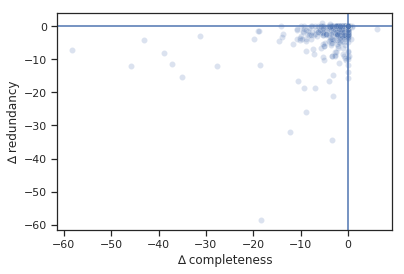

In [47]:
sns.set_style("ticks")
sns.scatterplot("delta_completeness", "delta_contamination", data=deltadict, alpha=0.2)
#plt.xlim([-12, 1])
#plt.ylim([-10,1])
plt.axhline(0)
plt.axvline(0)
plt.xlabel("∆ completeness")
plt.ylabel("∆ redundancy")
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(rootdir + "figures/delta.svg", format="svg")

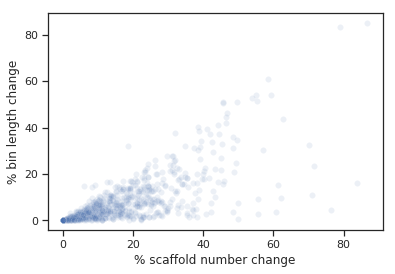

In [32]:
sns.scatterplot("delta_scafnum_perc", "delta_binlen_perc", data=deltadict, alpha=0.1)
plt.xlabel("% scaffold number change")
plt.ylabel("% bin length change")
#plt.xlim([0, 100])
#plt.ylim([0, 100])
plt.show()

### gunc comparison

In [226]:
cmdir(rootdir + "genomes/quality/gunc")
cmdir(rootdir + "genomes/quality/gunc/refined_gunc")

In [874]:
call = "gunc run -d %s -t 20 -o %s --detailed_output" %(rootdir + "genomes/refined_genomes", rootdir + "genomes/quality/gunc/refined_gunc")
print(call)

gunc run -d /groups/banfield/projects/environmental/LacPavin/analysis/genomes/refined_genomes -t 20 -o /groups/banfield/projects/environmental/LacPavin/analysis/genomes/quality/gunc/refined_gunc --detailed_output


In [33]:
grefined = pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "genomes/quality/gunc/refined_gunc/gunc_output/*")])
grefined["bin"] = grefined["genome"].apply(lambda x: x.split(".")[0])
grefineds = grefined[["bin", "taxonomic_level", "clade_separation_score", "contamination_portion"]]
grefineds.columns = ["bin", "taxonomic_level", "css_refined", "contam_refined"]
grefineds.head()

,bin,taxonomic_level,css_refined,contam_refined
0,A0818WC40_metabat_269,kingdom,0.00,0.00
1,A0818WC40_metabat_269,phylum,0.08,0.02
2,A0818WC40_metabat_269,class,0.00,0.00
3,A0818WC40_metabat_269,order,0.20,0.03
4,A0818WC40_metabat_269,family,0.21,0.03


In [34]:
goriginal= pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "genomes/quality/gunc/all_genomes_gunc/gunc_output/*")])
goriginal["bin"] = goriginal["genome"].apply(lambda x: x.replace(".", "_"))
goriginals = goriginal[["bin", "taxonomic_level", "clade_separation_score", "contamination_portion"]]
goriginals.columns = ["bin", "taxonomic_level", "css_original", "contam_original"]

In [35]:
gunc_merged = grefineds.merge(goriginals, how="left", on=["bin", "taxonomic_level"])
gunc_merged["delta_css"] = gunc_merged.apply(lambda x: x["css_refined"] - x["css_original"], axis=1)
gunc_merged["genome_slug"] = gunc_merged["bin"].apply(lambda x: x.replace("_sub", "").split("_contigs")[0])
gunc_merged.head()

,bin,taxonomic_level,css_refined,contam_refined,css_original,contam_original,delta_css,genome_slug
0,A0818WC40_metabat_269,kingdom,0.00,0.00,0.00,0.00,0.00,A0818WC40_metabat_269
1,A0818WC40_metabat_269,phylum,0.08,0.02,0.08,0.02,0.00,A0818WC40_metabat_269
2,A0818WC40_metabat_269,class,0.00,0.00,0.00,0.00,0.00,A0818WC40_metabat_269
3,A0818WC40_metabat_269,order,0.20,0.03,0.21,0.03,-0.01,A0818WC40_metabat_269
4,A0818WC40_metabat_269,family,0.21,0.03,0.21,0.04,0.00,A0818WC40_metabat_269


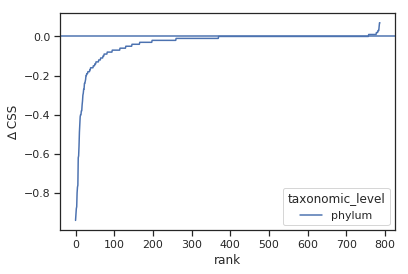

In [48]:
order = gunc_merged.query("taxonomic_level=='phylum'").sort_values("delta_css", ascending=True)["bin"].to_list()
gunc_merged["rank"] = gunc_merged["bin"].apply(lambda x: order.index(x))
sns.lineplot("rank", "delta_css", hue="taxonomic_level", data=gunc_merged.query("taxonomic_level=='phylum'"))
plt.axhline(0)
plt.ylabel("∆ CSS")
plt.savefig(rootdir + "figures/gunc_delta.svg", format="svg")

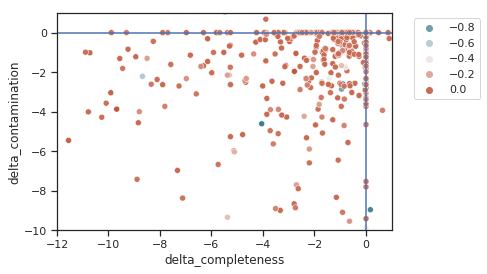

In [37]:
final_merge = deltadict.merge(gunc_merged.query("taxonomic_level=='phylum'"), on="genome_slug", how="left")
sns.set_style("ticks")
sns.scatterplot("delta_completeness", "delta_contamination", data=final_merge, hue="delta_css",palette=sns.diverging_palette(220, 20, as_cmap=True))
plt.xlim([-12, 1])
plt.ylim([-10,1])
plt.axhline(0)
plt.axvline(0)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### refinement stats

In [38]:
## lost
lost = final_merge[(final_merge["completeness"]>=70) & (final_merge["contamination"]<=10) & (final_merge["new_completeness"]<70)]
print("%f percent of the prelim set was lost during manual refinement." %(len(lost)/len(final_merge)*100))

2.157360 percent of the prelim set was lost during manual refinement.


In [39]:
## gained
gained = final_merge[(final_merge["new_completeness"]>=70) & (final_merge["contamination"]>10) & (final_merge["new_contamination"]<10)]
print("%f percent of the prelim set was gained during manual refinement." %(len(gained)/len(final_merge)*100))

5.583756 percent of the prelim set was gained during manual refinement.


In [40]:
## improved
improved = final_merge[(final_merge["delta_contamination"]<0) | (final_merge["delta_css"]<0)]
print("%f percent of the prelim set was improved in terms of either redundancy, chimerism, or both during manual refinement." %(len(improved)/len(final_merge)*100))

68.654822 percent of the prelim set was improved in terms of either redundancy, chimerism, or both during manual refinement.


In [41]:
## retained
retained = final_merge[(final_merge["new_contamination"]<=10) & (final_merge["new_completeness"]>=70)]
print("%f percent of the prelim set was retained after refinement, making %d genomes." %((len(retained)/len(final_merge)*100), len(retained)))

93.654822 percent of the prelim set was retained after refinement, making 738 genomes.


In [439]:
# write this out for later
final_merge.to_csv(rootdir + "tables/curation_data.tsv", sep="\t", index=False)

### create final genome set

In [283]:
cmdir(rootdir + "genomes/final_genomes")
cmdir(rootdir + "genomes/ani")

In [275]:
for key, row in final_merge.iterrows():
    if (row["new_completeness"]>=70) and (row["new_contamination"]<=10):
        genome_path = glob.glob(rootdir + "genomes/refined_genomes/" + row["genome_slug"] + "[._]*")
        call = "cp " + genome_path[0] + " " + rootdir + "genomes/final_genomes/"
        sp.call(call, shell=True)

In [435]:
# re-drep
call = "sbatch --wrap '/shared/software/bin/dRep compare -p 48 -sa 0.95 " + \
    rootdir + "/genomes/ani/ -g " + rootdir + "/genomes/final_genomes/*'"
print(call)

sbatch --wrap '/shared/software/bin/dRep compare -p 48 -sa 0.95 /groups/banfield/projects/environmental/LacPavin/analysis//genomes/ani/ -g /groups/banfield/projects/environmental/LacPavin/analysis//genomes/final_genomes/*'


In [436]:
# read in clustering 
clustering = pd.read_csv(rootdir + "genomes/ani/data_tables/Ndb.csv")
clustering[(clustering["querry"]!=clustering["reference"]) & (clustering["ani"]>=0.94)]

,querry,reference,alignment_length,similarity_errors,ref_coverage,querry_coverage,ani,reference_length,querry_length,alignment_coverage,primary_cluster
63,A0419WC70L_metabat_209.refined.fa,A0920SED2_metabat_60.refined.fa,1131354,59292,0.585000,0.726043,0.947592,1933937,1558246,0.726043,490
64,A0920SED2_metabat_60.refined.fa,A0419WC70L_metabat_209.refined.fa,1133343,59111,0.727320,0.586029,0.947844,1558246,1933937,0.727320,490
71,A0419WC70L_metabat_27.refined.fa,A0419WC90_metabat_67.refined.fa,1502263,79061,0.743378,0.834814,0.947372,2020861,1799518,0.834814,497
72,A0419WC90_metabat_67.refined.fa,A0419WC70L_metabat_27.refined.fa,1506724,79588,0.837293,0.745585,0.947178,1799518,2020861,0.837293,497


In [437]:
len(pd.read_csv(rootdir + "genomes/ani/data_tables/Cdb.csv")["secondary_cluster"].unique())

738